# Imports

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, desc, col, round, expr, count, first
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [3]:
spark = SparkSession.builder \
    .appName("Análisis de eventos de comercio electrónico") \
    .getOrCreate()

In [5]:
#octubre
df1 = spark.read.format("csv").option("header", "true").load("C:/Users/User/Desktop/data/2019-Oct.csv")
#noviembre
df2 = spark.read.format("csv").option("header", "true").load("C:/Users/User/Desktop/data/2019-Nov.csv")
#diciembre
df3 = spark.read.format("csv").option("header", "true").load("C:/Users/User/Desktop/data/2019-Dec.csv")
#enero
df4= spark.read.format("csv").option("header", "true").load("C:/Users/User/Desktop/data/2020-Jan.csv")
#febrero
df5 = spark.read.format("csv").option("header", "true").load("C:/Users/User/Desktop/data/2020-Feb.csv")


# Data discovery 

## Monthly and Totally Data:

Almost 21 million of transactions recorded in 5 months

In [6]:
octubre= df1.count()
noviembre= df2.count()
diciembre= df3.count()
enero= df4.count()
febrero= df5.count()

In [7]:
print("por orden (octubre,noviembre,diciembre,enero,febrero): ",octubre,noviembre,diciembre,enero,febrero)
print("total: "+ str(octubre+noviembre+diciembre+enero+febrero))

por orden (octubre,noviembre,diciembre,enero,febrero):  4102283 4635837 3533286 4264752 4156682
total: 20692840


## Unique users per month
January registers the greatest amount of individual users. Also we can see a little drop down in the quatity of users in november and december in comparison with october

In [8]:
unique_users = df1.select('user_id').distinct().count()
unique_users1 = df2.select('user_id').distinct().count()
unique_users2 = df3.select('user_id').distinct().count()
unique_users3 = df4.select('user_id').distinct().count()
unique_users4= df5.select('user_id').distinct().count()

399664 368232 370154 410073 391055


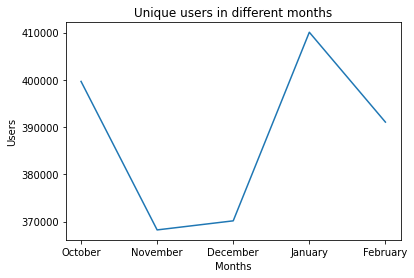

In [10]:
print(unique_users,unique_users1,unique_users2,unique_users3, unique_users4)
users=np.array([unique_users,unique_users1,unique_users2,unique_users3, unique_users4])
months=np.array(["October", "November", "December","January", "February"])

plt.plot( months,users)
plt.xlabel("Months")
plt.ylabel("Users")
plt.title("Unique users in different months")
plt.xticks(np.arange(len(months)), months)  # Establecer las marcas en el eje x
plt.show()

## Average activity for users:
We can see that the average activity changes in November and December, Why does that happen?

In [11]:
events_octubre = octubre / unique_users
events_nov = noviembre / unique_users1
events_dic = diciembre / unique_users2
events_en = enero / unique_users3
events_feb = febrero / unique_users4
print(events_octubre, events_nov, events_dic,events_en,events_feb)

10.264329536810921 12.589446327315388 9.545448651101974 10.399982442150543 10.629405070897956


The average activity does not mean that those months are really the ones with the highest sales.
This is because the activity is monitored in 3 cases (purchase, cart, remove from cart), so it can be a month with a lot of activity but it can be the month with the lowest incomes.

Let´s figure which month has the greatest sales:

In [12]:
sales_oct = df1.filter(col('event_type') == 'purchase')
total_sales_oct = sales_oct.count()

sales_nov = df2.filter(col('event_type') == 'purchase')
total_sales_nov = sales_nov.count()

sales_dec = df3.filter(col('event_type') == 'purchase')
total_sales_dec = sales_dec.count()

sales_jan = df4.filter(col('event_type') == 'purchase')
total_sales_jan = sales_jan.count()

sales_feb = df5.filter(col('event_type') == 'purchase')
total_sales_feb = sales_feb.count()
# Mostrar el resultado
print("Total de sales octubre:", total_sales_oct)
print("Total de sales nov:", total_sales_nov)
print("Total de sales dic:", total_sales_dec)
print("Total de sales en:", total_sales_jan)
print("Total de sales feb:", total_sales_feb)


Total de sales octubre: 245624
Total de sales nov: 322417
Total de sales dic: 213176
Total de sales en: 263797
Total de sales feb: 241993


Supricely the month with the lowest sales it´s december even when Christmas and New year are the main events that month.
Nevertheless November records the most sales, this could be suspected but ¿why and when? ¿Does the prices lower in november? ¿it´s black friday the main event for sales in november? Let´s find out:

### Black friday (24/11/year):
Only 6% of the november sales are made on november 24.

In [13]:
sales_24_nov = df2.filter((col('event_type') == 'purchase') & (col('event_time').contains('2019-11-24')))
total_sales_24_nov = sales_24_nov.count()

# Mostrar el resultado
print("Total de compras el 24 de noviembre:", total_sales_24_nov)
print("porcentaje de ventas= ", str((total_sales_24_nov/322417) *100)+"%")

Total de compras el 24 de noviembre: 20464
porcentaje de ventas=  6.347059863468737%


## Prices
There are few ways to study this variable, here we are going to do in two ways:
One it´s to summarize the total price of items and divide it for the quantity of items per month.
Another one its to compare the price of popular items in diferent dates wondering to expect lower prices in the month of november in comparison with december and octuber.


#### Summatory / Quantity

In [14]:
#October
distinct_oct = df1.select("product_id", "price").distinct()
summ_oct = distinct_oct.agg(sum("price")).collect()[0][0]
x=distinct_oct.count()
print("Summ oct:", summ_oct)
print("quantity:",x)
print("division:",summ_oct/x)

#November
distinct_nov = df2.select("product_id", "price").distinct()
summ_nov = distinct_nov.agg(sum("price")).collect()[0][0]
y=distinct_nov.count()
print("Summ nov:", summ_nov)
print("quantity:",y)
print("division:",summ_nov/y)


#December
distinct_dec = df3.select("product_id", "price").distinct()
summ_dec = distinct_dec.agg(sum("price")).collect()[0][0]
z=distinct_dec.count()
print("Summ dec:", summ_dec)
print("quantity:",z)
print("division:",summ_dec/z)


#January
distinct_jan = df4.select("product_id", "price").distinct()
summ_jan = distinct_jan.agg(sum("price")).collect()[0][0]
w=distinct_jan.count()
print("Summ jan:", summ_jan)
print("quantity:",w)
print("division:",summ_jan/w)

#February
distinct_feb = df5.select("product_id", "price").distinct()
summ_feb = distinct_feb.agg(sum("price")).collect()[0][0]
a=distinct_feb.count()
print("Summ feb:", summ_feb)
print("quantity:",a)
print("division:",summ_feb/a)

Summ oct: 337514.72999999777
quantity: 45026
division: 7.495996313241188
Summ nov: 569835.5400000033
quantity: 83274
division: 6.8428986238202
Summ dec: 380274.4999999971
quantity: 50870
division: 7.475417731472324
Summ jan: 379835.5999999979
quantity: 48912
division: 7.765693490349973
Summ feb: 423588.77999999473
quantity: 70248
division: 6.029905193030332


November and February with this metric are the cheapest months for buying in the eCommerce, ofCourse this is not a significant metric, because it can be a lot of cheapest articles and a few really expensive, Nonetheless we coud observe that November is  the month with the hugest inventary almost doubling the inventory of the previous and the following months.
Also it would be interesting to discover if exists differecences between prices of the same articles in the diferent moths. This is why the following section will try to respond that question


#### Differences between months

For this we want to compare which items are the same in the diferent months and compare de prices summing de diference between the prices. 
If de difference is possitive the prices of the previous month are higher than the other. 

As we were mentioned, our hypothesis was that February and November where the months with the cheapest prices, so we will compare de prices of the months and conclude.

##### October vs November

In [15]:
# Calcular los n productos más populares de cada dataset
df1_top_300 = df1.groupBy("product_id").agg(count("*").alias("count_df1"), first("price").alias("price_df1")).orderBy(col("count_df1").desc())
df2_top_300 = df2.groupBy("product_id").agg(count("*").alias("count_df2"), first("price").alias("price_df2")).orderBy(col("count_df2").desc())

df1_top_300 = df1_top_300.withColumnRenamed("price", "price_df1")
df2_top_300 = df2_top_300.withColumnRenamed("price", "price_df2")
df1_top_300 = df1_top_300.withColumnRenamed("product_id", "product_id_df1")
df2_top_300 = df2_top_300.withColumnRenamed("product_id", "product_id_df2")
df1_top_300 = df1_top_300.withColumnRenamed("count", "count_df1")
df2_top_300 = df2_top_300.withColumnRenamed("count", "count_df2")



# # Encontrar los productos con el mismo ID en ambos datasets
common_products = df1_top_300.join(df2_top_300, df1_top_300["product_id_df1"] == df2_top_300["product_id_df2"])
# # Renombrar columnas si es necesario
print(common_products.count())
# # Calcular la diferencia de precios y la suma de las diferencias
common_products_with_diff = common_products.withColumn("price_diff", col("price_df1") - col("price_df2"))
total_price_diff = common_products_with_diff.agg({"price_diff": "sum"}).collect()[0][0]

# # Mostrar la suma de las diferencias de precios
print("Total Price Difference:", total_price_diff)


39358
Total Price Difference: -11981.120000000003


##### November vs December

In [16]:
# Calcular los n productos más populares de cada dataset
df1_top_300 = df2.groupBy("product_id").agg(count("*").alias("count_df1"), first("price").alias("price_df1")).orderBy(col("count_df1").desc())
df2_top_300 = df3.groupBy("product_id").agg(count("*").alias("count_df2"), first("price").alias("price_df2")).orderBy(col("count_df2").desc())

df1_top_300 = df1_top_300.withColumnRenamed("price", "price_df1")
df2_top_300 = df2_top_300.withColumnRenamed("price", "price_df2")
df1_top_300 = df1_top_300.withColumnRenamed("product_id", "product_id_df1")
df2_top_300 = df2_top_300.withColumnRenamed("product_id", "product_id_df2")
df1_top_300 = df1_top_300.withColumnRenamed("count", "count_df1")
df2_top_300 = df2_top_300.withColumnRenamed("count", "count_df2")



# # Encontrar los productos con el mismo ID en ambos datasets
common_products = df1_top_300.join(df2_top_300, df1_top_300["product_id_df1"] == df2_top_300["product_id_df2"])
# # Renombrar columnas si es necesario
print(common_products.count())
# # Calcular la diferencia de precios y la suma de las diferencias
common_products_with_diff = common_products.withColumn("price_diff", col("price_df1") - col("price_df2"))
total_price_diff = common_products_with_diff.agg({"price_diff": "sum"}).collect()[0][0]

# # Mostrar la suma de las diferencias de precios
print("Total Price Difference:", total_price_diff)

40346
Total Price Difference: -8637.64


##### December vs January

In [17]:
# Calcular los n productos más populares de cada dataset
df1_top_300 = df3.groupBy("product_id").agg(count("*").alias("count_df1"), first("price").alias("price_df1")).orderBy(col("count_df1").desc())
df2_top_300 = df4.groupBy("product_id").agg(count("*").alias("count_df2"), first("price").alias("price_df2")).orderBy(col("count_df2").desc())

df1_top_300 = df1_top_300.withColumnRenamed("price", "price_df1")
df2_top_300 = df2_top_300.withColumnRenamed("price", "price_df2")
df1_top_300 = df1_top_300.withColumnRenamed("product_id", "product_id_df1")
df2_top_300 = df2_top_300.withColumnRenamed("product_id", "product_id_df2")
df1_top_300 = df1_top_300.withColumnRenamed("count", "count_df1")
df2_top_300 = df2_top_300.withColumnRenamed("count", "count_df2")



# # Encontrar los productos con el mismo ID en ambos datasets
common_products = df1_top_300.join(df2_top_300, df1_top_300["product_id_df1"] == df2_top_300["product_id_df2"])
# # Renombrar columnas si es necesario
# # Calcular la diferencia de precios y la suma de las diferencias
common_products_with_diff = common_products.withColumn("price_diff", col("price_df1") - col("price_df2"))
print(common_products.count())
total_price_diff = common_products_with_diff.agg({"price_diff": "sum"}).collect()[0][0]

# # Mostrar la suma de las diferencias de precios
print("Total Price Difference:", total_price_diff)

41806
Total Price Difference: -22907.929999999993


##### January vs February

In [18]:
# Calcular los n productos más populares de cada dataset
df1_top_300 = df4.groupBy("product_id").agg(count("*").alias("count_df1"), first("price").alias("price_df1")).orderBy(col("count_df1").desc())
df2_top_300 = df5.groupBy("product_id").agg(count("*").alias("count_df2"), first("price").alias("price_df2")).orderBy(col("count_df2").desc())

df1_top_300 = df1_top_300.withColumnRenamed("price", "price_df1")
df2_top_300 = df2_top_300.withColumnRenamed("price", "price_df2")
df1_top_300 = df1_top_300.withColumnRenamed("product_id", "product_id_df1")
df2_top_300 = df2_top_300.withColumnRenamed("product_id", "product_id_df2")
df1_top_300 = df1_top_300.withColumnRenamed("count", "count_df1")
df2_top_300 = df2_top_300.withColumnRenamed("count", "count_df2")

# Encontrar los productos con el mismo ID en ambos datasets
common_products = df1_top_300.join(df2_top_300, df1_top_300["product_id_df1"] == df2_top_300["product_id_df2"])
# # Renombrar columnas si es necesario
# # Calcular la diferencia de precios y la suma de las diferencias
common_products_with_diff = common_products.withColumn("price_diff", col("price_df1") - col("price_df2"))
print(common_products.count())
total_price_diff = common_products_with_diff.agg({"price_diff": "sum"}).collect()[0][0]

# # Mostrar la suma de las diferencias de precios
print("Total Price Difference:", total_price_diff)

43139
Total Price Difference: 4640.420000000007


##### October vs December

In [60]:
# Calcular los n productos más populares de cada dataset
df1_top_300 = df1.groupBy("product_id").agg(count("*").alias("count_df1"), first("price").alias("price_df1")).orderBy(col("count_df1").desc())
df2_top_300 = df3.groupBy("product_id").agg(count("*").alias("count_df2"), first("price").alias("price_df2")).orderBy(col("count_df2").desc())

df1_top_300 = df1_top_300.withColumnRenamed("price", "price_df1")
df2_top_300 = df2_top_300.withColumnRenamed("price", "price_df2")
df1_top_300 = df1_top_300.withColumnRenamed("product_id", "product_id_df1")
df2_top_300 = df2_top_300.withColumnRenamed("product_id", "product_id_df2")
df1_top_300 = df1_top_300.withColumnRenamed("count", "count_df1")
df2_top_300 = df2_top_300.withColumnRenamed("count", "count_df2")

# Encontrar los productos con el mismo ID en ambos datasets
common_products = df1_top_300.join(df2_top_300, df1_top_300["product_id_df1"] == df2_top_300["product_id_df2"])
# # Renombrar columnas si es necesario
# # Calcular la diferencia de precios y la suma de las diferencias
common_products_with_diff = common_products.withColumn("price_diff", col("price_df1") - col("price_df2"))
print(common_products.count())
total_price_diff = common_products_with_diff.agg({"price_diff": "sum"}).collect()[0][0]

# # Mostrar la suma de las diferencias de precios
print("Total Price Difference:", total_price_diff)

38468


Total Price Difference: -13616.390000000025


#### Conclution
As observed, the behavior observed in the first data analysis approach is sustained. After conducting various comparisons between different dates, it is clear that the highest price difference is achieved when comparing with the month of January (which previously showed the highest price index), while the lowest difference is obtained when comparing with February and then November. Furthermore, it can be concluded that there are consistent increases in prices, as suspected due to supply and demand dynamics. However, such significant differences between each month were not expected.
